<a href="https://colab.research.google.com/github/onurercen/workout_prediction_app/blob/main/decision_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Colab için gerekli kurulumlar
!pip install imbalanced-learn -q

# Veri setini yükle
from google.colab import files
uploaded = files.upload()

Saving gym_members_exercise_tracking.csv to gym_members_exercise_tracking (1).csv


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_absolute_error
from sklearn.tree import DecisionTreeClassifier, plot_tree
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Veri yükleme
df = pd.read_csv("gym_members_exercise_tracking.csv")
df = df.dropna()
df.reset_index(drop=True, inplace=True)

print("="*70)
print("EXPERIENCE LEVEL PREDICTION - DECISION TREE MODEL")
print("="*70)
print(f"\nVeri seti boyutu: {df.shape}")

EXPERIENCE LEVEL PREDICTION - DECISION TREE MODEL

Veri seti boyutu: (973, 15)


In [4]:
# Target analizi
print("\nExperience Level Dağılımı:")
print(df["Experience_Level"].value_counts().sort_index())
print(f"\nExperience Level oranları:")
print(df["Experience_Level"].value_counts(normalize=True).sort_index())


Experience Level Dağılımı:
Experience_Level
1    376
2    406
3    191
Name: count, dtype: int64

Experience Level oranları:
Experience_Level
1    0.386434
2    0.417266
3    0.196300
Name: proportion, dtype: float64


In [5]:
# FEATURE ENGINEERING
print("\n" + "="*70)
print("FEATURE ENGINEERING")
print("="*70)

df["HR_per_minute"] = df["Avg_BPM"] / (df["Session_Duration (hours)"] * 60)
df["Intensity_per_Weight"] = df["Calories_Burned"] / df["Weight (kg)"]
df["HRR"] = df["Max_BPM"] - df["Resting_BPM"]
df["Efficiency"] = df["Calories_Burned"] / df["Avg_BPM"]
df["Anaerobic_Index"] = (df["Max_BPM"] - df["Avg_BPM"]) / df["Resting_BPM"]
df["BPM_Variance_Rest"] = (df["Avg_BPM"] - df["Resting_BPM"]) ** 2
df["Heart_Instability"] = abs(df["Max_BPM"] - df["Avg_BPM"]) / df["Max_BPM"]
df["Calories_per_Hour"] = df["Calories_Burned"] / df["Session_Duration (hours)"]
df["Heart_Efficiency"] = df["Calories_Burned"] / df["HRR"]
df["BMI_Category"] = pd.cut(df["BMI"], bins=[0, 18.5, 25, 30, 100], labels=[0, 1, 2, 3]).astype(int)
df["Age_Group"] = pd.cut(df["Age"], bins=[0, 25, 35, 45, 100], labels=[0, 1, 2, 3]).astype(int)


FEATURE ENGINEERING


In [6]:
# Deneyim ile ilgili ek feature'lar
df["Workout_Intensity"] = df["Calories_Burned"] * df["Max_BPM"] / 1000
df["Performance_Score"] = df["Calories_Burned"] * df["Workout_Frequency (days/week)"]
df["Fitness_Level"] = df["HRR"] / df["Resting_BPM"]
df["Training_Load"] = df["Session_Duration (hours)"] * df["Workout_Frequency (days/week)"] * df["Avg_BPM"]

print(f"Toplam {len([col for col in df.columns if col in ['HR_per_minute', 'Intensity_per_Weight', 'HRR', 'Efficiency', 'Anaerobic_Index', 'BPM_Variance_Rest', 'Heart_Instability', 'Calories_per_Hour', 'Heart_Efficiency', 'BMI_Category', 'Age_Group', 'Workout_Intensity', 'Performance_Score', 'Fitness_Level', 'Training_Load']])} yeni feature oluşturuldu")


Toplam 15 yeni feature oluşturuldu


In [7]:
# Label Encoding
le_gender = LabelEncoder()
le_workout = LabelEncoder()

df["Gender_Code"] = le_gender.fit_transform(df["Gender"])
df["Workout_Code"] = le_workout.fit_transform(df["Workout_Type"])


In [8]:
# Feature Selection - Experience Level'ı ÇIKARIYORUZ (target olacak)
feature_cols = [
    'Age', 'Gender_Code', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM',
    'Session_Duration (hours)', 'Calories_Burned', 'Workout_Frequency (days/week)',
    'Fat_Percentage', 'Water_Intake (liters)', 'Workout_Code', 'BMI',
    'HR_per_minute', 'Intensity_per_Weight', 'HRR', 'Efficiency',
    'Anaerobic_Index', 'BPM_Variance_Rest', 'Heart_Instability',
    'Calories_per_Hour', 'Heart_Efficiency', 'BMI_Category', 'Age_Group',
    'Workout_Intensity', 'Performance_Score', 'Fitness_Level', 'Training_Load'
]

X = df[feature_cols]
y = df['Experience_Level']

print(f"\nFeature sayısı: {X.shape[1]}")
print(f"Target (Experience Level): {y.name}")



Feature sayısı: 29
Target (Experience Level): Experience_Level


In [9]:
# Split the data as train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

print(f"\nTrain set: {X_train.shape}")
print(f"Test set: {X_test.shape}")


Train set: (681, 29)
Test set: (292, 29)


In [10]:
# Class imbalance kontrol
print("\nTrain set dağılımı:")
print(pd.Series(y_train).value_counts().sort_index())


Train set dağılımı:
Experience_Level
1    263
2    284
3    134
Name: count, dtype: int64


In [11]:
# SMOTE (opsiyonel - zaten dengeli ama deneyelim)
use_smote = False  # Gerekirse True yap

if use_smote:
    sm = SMOTE(random_state=42, k_neighbors=5)
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
    print(f"\nSMOTE sonrası train set: {X_train_res.shape}")
    print("SMOTE sonrası dağılım:")
    print(pd.Series(y_train_res).value_counts().sort_index())
else:
    X_train_res, y_train_res = X_train, y_train
    print("\nSMOTE kullanılmıyor (veri zaten dengeli)")


SMOTE kullanılmıyor (veri zaten dengeli)


In [12]:
# DECISION TREE MODEL EĞİTİMİ
print("\n" + "="*70)
print("DECISION TREE MODEL EĞİTİMİ")
print("="*70)

# Baseline model
dt_model = DecisionTreeClassifier(
    random_state=42,
    criterion='gini',
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2
)

print("Model eğitiliyor...")
dt_model.fit(X_train_res, y_train_res)

# Tahmin
y_pred = dt_model.predict(X_test)

# Performans metrikleri
accuracy = accuracy_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("\n" + "="*70)
print("MODEL PERFORMANSI")
print("="*70)
print(f"\nAccuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Mean Absolute Error: {mae:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Level 1', 'Level 2', 'Level 3']))


DECISION TREE MODEL EĞİTİMİ
Model eğitiliyor...

MODEL PERFORMANSI

Accuracy: 0.8459 (84.59%)
Mean Absolute Error: 0.1541

Classification Report:
              precision    recall  f1-score   support

     Level 1       0.77      0.86      0.81       113
     Level 2       0.85      0.76      0.81       122
     Level 3       1.00      1.00      1.00        57

    accuracy                           0.85       292
   macro avg       0.87      0.87      0.87       292
weighted avg       0.85      0.85      0.85       292



In [13]:
# Cross-Validation
print("\n" + "="*70)
print("CROSS-VALIDATION (5-Fold)")
print("="*70)

cv_scores = cross_val_score(dt_model, X, y, cv=5, scoring='accuracy')
print(f"\nCV Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")


CROSS-VALIDATION (5-Fold)

CV Scores: [0.85128205 0.82564103 0.8974359  0.82989691 0.8814433 ]
Mean CV Accuracy: 0.8571 (+/- 0.0564)


In [14]:
# GridSearchCV ile Hyperparameter Tuning
print("\n" + "="*70)
print("HYPERPARAMETER TUNING (GridSearchCV)")
print("="*70)

param_grid = {
    'max_depth': [5, 8, 10, 12, 15, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("Grid Search başlatılıyor...")
grid_search.fit(X_train_res, y_train_res)

print(f"\nEn iyi parametreler: {grid_search.best_params_}")
print(f"En iyi CV accuracy: {grid_search.best_score_:.4f}")


HYPERPARAMETER TUNING (GridSearchCV)
Grid Search başlatılıyor...
Fitting 5 folds for each of 192 candidates, totalling 960 fits

En iyi parametreler: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}
En iyi CV accuracy: 0.8854


In [16]:
# En iyi model ile tahmin
best_dt_model = grid_search.best_estimator_
y_pred_best = best_dt_model.predict(X_test)

best_accuracy = accuracy_score(y_test, y_pred_best)
best_mae = mean_absolute_error(y_test, y_pred_best)

print("\n" + "="*70)
print("OPTİMİZE EDİLMİŞ MODEL PERFORMANSI")
print("="*70)
print(f"\nAccuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")
print(f"Mean Absolute Error: {best_mae:.4f}")

print("\nClassification Report (Optimized):")
print(classification_report(y_test, y_pred_best, target_names=['Level 1', 'Level 2', 'Level 3']))


OPTİMİZE EDİLMİŞ MODEL PERFORMANSI

Accuracy: 0.9075 (90.75%)
Mean Absolute Error: 0.0925

Classification Report (Optimized):
              precision    recall  f1-score   support

     Level 1       0.99      0.77      0.87       113
     Level 2       0.82      0.99      0.90       122
     Level 3       1.00      1.00      1.00        57

    accuracy                           0.91       292
   macro avg       0.94      0.92      0.92       292
weighted avg       0.92      0.91      0.91       292



In [17]:
# Feature Importance
print("\n" + "="*70)
print("FEATURE IMPORTANCE")
print("="*70)

feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': best_dt_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 15 Önemli Feature:")
print(feature_importance.head(15).to_string(index=False))


FEATURE IMPORTANCE

Top 15 Önemli Feature:
                      Feature  Importance
     Session_Duration (hours)    0.584843
                Training_Load    0.274909
Workout_Frequency (days/week)    0.127083
                      Avg_BPM    0.011705
            Performance_Score    0.001459
                      Max_BPM    0.000000
                   Height (m)    0.000000
                  Weight (kg)    0.000000
                  Resting_BPM    0.000000
              Calories_Burned    0.000000
               Fat_Percentage    0.000000
                  Gender_Code    0.000000
                          Age    0.000000
                 Workout_Code    0.000000
        Water_Intake (liters)    0.000000


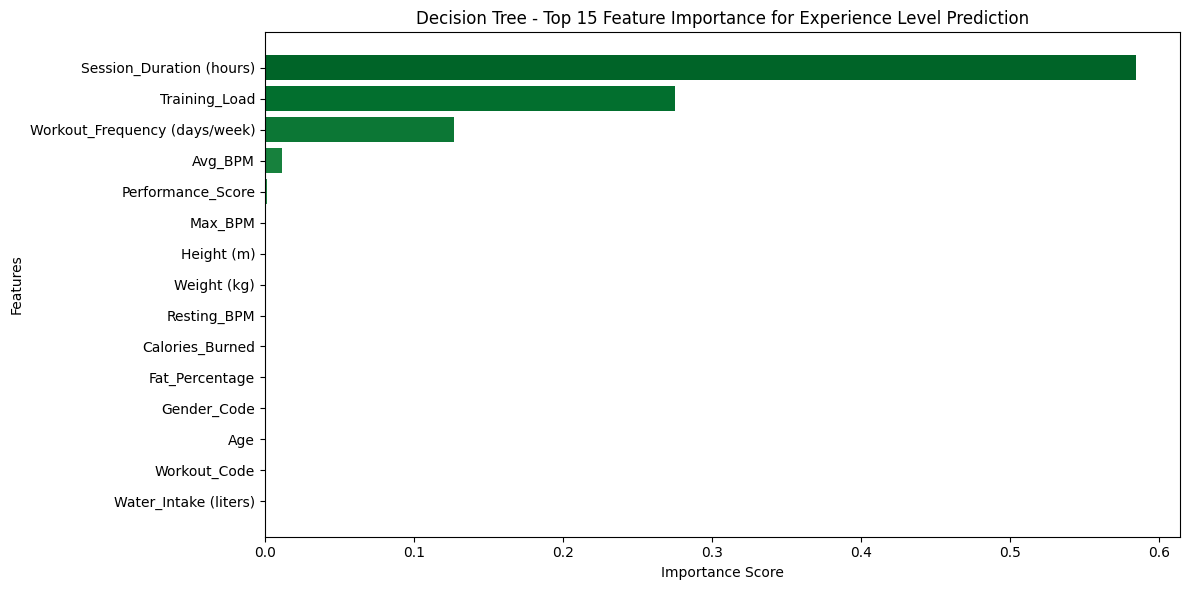

In [18]:
# Feature Importance Visualization
plt.figure(figsize=(12, 6))
top_features = feature_importance.head(15)
colors = plt.cm.Greens(np.linspace(0.4, 0.9, len(top_features)))
bars = plt.barh(top_features['Feature'], top_features['Importance'], color=colors[::-1])
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Decision Tree - Top 15 Feature Importance for Experience Level Prediction')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('dt_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

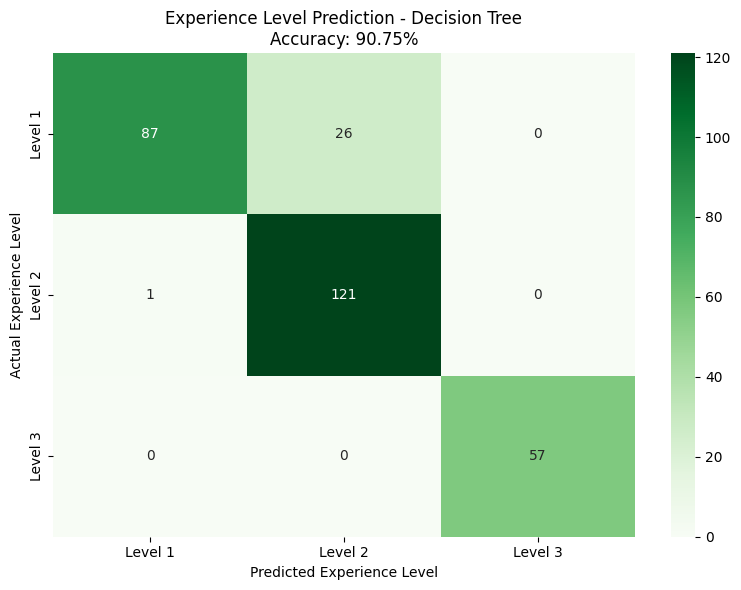

In [19]:
# Confusion Matrix
cm_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Level 1', 'Level 2', 'Level 3'],
            yticklabels=['Level 1', 'Level 2', 'Level 3'])
plt.title(f'Experience Level Prediction - Decision Tree\nAccuracy: {best_accuracy:.2%}')
plt.xlabel('Predicted Experience Level')
plt.ylabel('Actual Experience Level')
plt.tight_layout()
plt.savefig('dt_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

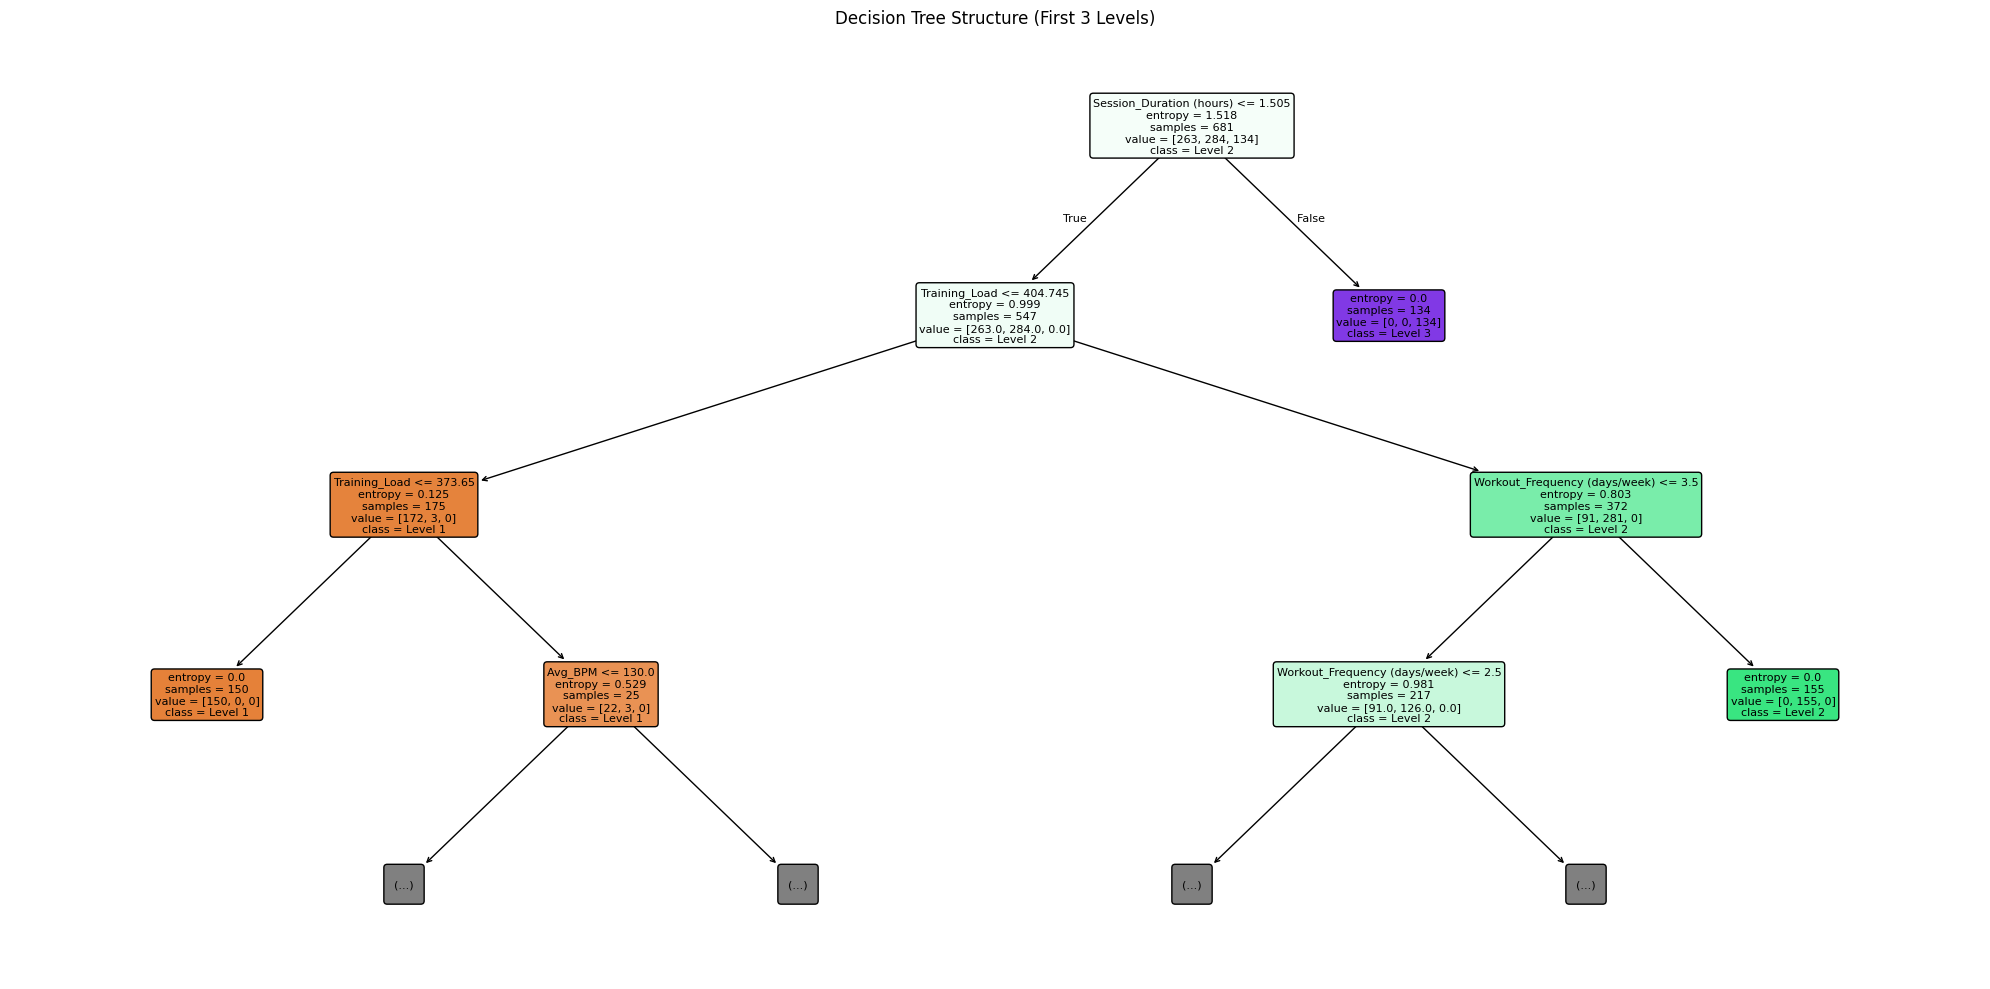

In [20]:
# Decision Tree Visualization (Küçük ağaç için)
plt.figure(figsize=(20, 10))
plot_tree(best_dt_model,
          feature_names=feature_cols,
          class_names=['Level 1', 'Level 2', 'Level 3'],
          filled=True,
          rounded=True,
          max_depth=3,  # İlk 3 seviye
          fontsize=8)
plt.title('Decision Tree Structure (First 3 Levels)')
plt.tight_layout()
plt.savefig('dt_tree_structure.png', dpi=150, bbox_inches='tight')
plt.show()

In [21]:
# Hata Analizi
print("\n" + "="*70)
print("HATA ANALİZİ")
print("="*70)

errors = y_test != y_pred_best
error_df = X_test[errors].copy()
error_df['Actual'] = y_test[errors].values
error_df['Predicted'] = y_pred_best[errors]
error_df['Error'] = abs(error_df['Actual'] - error_df['Predicted'])

print(f"\nToplam hatalı tahmin: {errors.sum()} / {len(y_test)}")
print(f"Hata oranı: {errors.sum()/len(y_test)*100:.2f}%")

if errors.sum() > 0:
    print("\nHata dağılımı:")
    print(error_df['Error'].value_counts().sort_index())
    print("\nEn çok karıştırılan tahminler:")
    print(error_df.groupby(['Actual', 'Predicted']).size().sort_values(ascending=False))


HATA ANALİZİ

Toplam hatalı tahmin: 27 / 292
Hata oranı: 9.25%

Hata dağılımı:
Error
1    27
Name: count, dtype: int64

En çok karıştırılan tahminler:
Actual  Predicted
1       2            26
2       1             1
dtype: int64


In [24]:
# Model Özeti
print("\n" + "="*70)
print("DECISION TREE MODEL ÖZETİ")
print("="*70)

print(f"\n Model Bilgileri:")
print(f"   - Model: Decision Tree Classifier")
print(f"   - En iyi parametreler: {grid_search.best_params_}")
print(f"   - Ağaç derinliği: {best_dt_model.get_depth()}")
print(f"   - Yaprak sayısı: {best_dt_model.get_n_leaves()}")

print(f"\n Performans Metrikleri:")
print(f"   - Final Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")
print(f"   - CV Mean Accuracy: {grid_search.best_score_:.4f}")
print(f"   - Mean Absolute Error: {best_mae:.4f}")

print(f"\n En Önemli 5 Feature:")
for i, row in feature_importance.head(5).iterrows():
    print(f"   {feature_importance.iloc[list(feature_importance.index).index(i)]['Feature']}: {feature_importance.iloc[list(feature_importance.index).index(i)]['Importance']:.4f}")



DECISION TREE MODEL ÖZETİ

 Model Bilgileri:
   - Model: Decision Tree Classifier
   - En iyi parametreler: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}
   - Ağaç derinliği: 5
   - Yaprak sayısı: 9

 Performans Metrikleri:
   - Final Accuracy: 0.9075 (90.75%)
   - CV Mean Accuracy: 0.8854
   - Mean Absolute Error: 0.0925

 En Önemli 5 Feature:
   Session_Duration (hours): 0.5848
   Training_Load: 0.2749
   Workout_Frequency (days/week): 0.1271
   Avg_BPM: 0.0117
   Performance_Score: 0.0015
